In [1]:
import torch
from torchvision import transforms
from score_models import ScoreModel, EnergyModel, NCSNpp, MLP, DDPM
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
from PIL import Image

In [9]:
score_model = ScoreModel(seed = 0, checkpoints_directory="/home/mjybarth/scratch/cats_2_checkpoints")
device = "cuda"

Loaded checkpoint 1 of cats_2_checkpoints
Using the Variance Exploding SDE


In [14]:
img_size = 64

In [230]:
def sigma(t):
    return score_model.sde.sigma(t)

def mu(t):
    return score_model.sde.marginal_prob_scalars(t)[0]

def model(x, t):
    return x

def score_posterior(x, t): 
    x = x.reshape(-1, 1, img_size, img_size)
    return score_model.score(t, x).flatten(start_dim = 1)# + score_likelihood(y, x, t, sigma_y) 

def g(t, x):
    return score_model.sde.diffusion(t, x)

def drift_fn(t, x):
    return score_model.sde.drift(t, x)
    

def pc_sampler(num_samples, num_pred_steps, num_corr_steps, score_function, snr = 1e-2, img_size = 28): 
    # THIS CODE IS WRONG....FIX IT LATER!!!
    # THIS CODE IS WRONG....FIX IT LATER!!!
    # THIS CODE IS WRONG....FIX IT LATER!!!
    t = torch.ones(size = (num_samples, 1)).to(device)
    x = torch.randn([num_samples, img_size ** 2]).to(device) * sigma(t)
    dt = -1/num_pred_steps
    with torch.no_grad(): 
        for _ in tqdm(range(num_pred_steps-1)): 
            # Corrector step: (Only if we are not at 0 temperature )
            gradient = score_function(x, t)
            for _ in range(num_corr_steps): 
                z = torch.randn_like(x)
                grad_norm = torch.mean(torch.norm(gradient, dim = -1)) # mean of the norm of the score over the batch 
                noise_norm = torch.mean(torch.norm(z, dim = -1))
                epsilon =  2 * (snr * noise_norm / grad_norm) ** 2
                x = x + epsilon * gradient + (2 * epsilon) ** 0.5 * z * dt  

        
            # Predictor step: 
            z = torch.randn_like(x).to(device)
            gradient = score_function(x, t)
            drift = drift_fn(t, x)
            diffusion = g(t, x)
            x_mean = x - diffusion**2 * gradient * dt  
            noise = diffusion * (-dt) ** 0.5 * z
            x = x_mean + noise
            t += dt
            if torch.any(torch.isnan(x_mean)):
                print("Nans appearing")
                break
            
    return torch.flip(link_function(x_mean).reshape(num_samples, img_size, img_size), dims = (2,))

def euler_sampler(num_samples, num_steps, score_function, img_size = 64): 
    t = torch.ones(size = (num_samples, 1)).to(device)
    x = torch.randn([num_samples, img_size ** 2]).to(device) * sigma(t)
    dt = -1/num_steps
    
    chain = []
    with torch.no_grad(): 
        for _ in (pbar := tqdm(range(num_steps - 1))): 
            pbar.set_description(f"t = {t[0].item():.2f} | scale ~ {x.std():.2e} | sigma(t) = {sigma(t)[0].item():.2e} | mu(t) = {mu(t)[0].item():.2e}")
            t += dt
            z = torch.randn_like(x).to(device)
            gradient = score_function(x, t)
            drift = drift_fn(t, x)
            diffusion = g(t, x)
            x_mean = x + drift * dt - diffusion**2 * gradient * dt  
            noise = diffusion * (-dt) ** 0.5 * z
            x = x_mean + noise
            
            chain.append(x.cpu().numpy())

            #print(score_likelihood(x, t))
            if torch.any(torch.isnan(x_mean)):
                print("Nans appearing")
                break
    
    return torch.flip(x_mean.reshape(num_samples, img_size, img_size), dims = (2,)), chain

In [231]:
pred = 1000
samples, chain = euler_sampler(num_samples = 1, num_steps = pred, score_function = score_posterior, img_size = 64)

t = 0.00 | scale ~ 4.15e-01 | sigma(t) = 1.02e-02 | mu(t) = 1.00e+00: 100%|██████████| 999/999 [00:17<00:00, 58.75it/s]


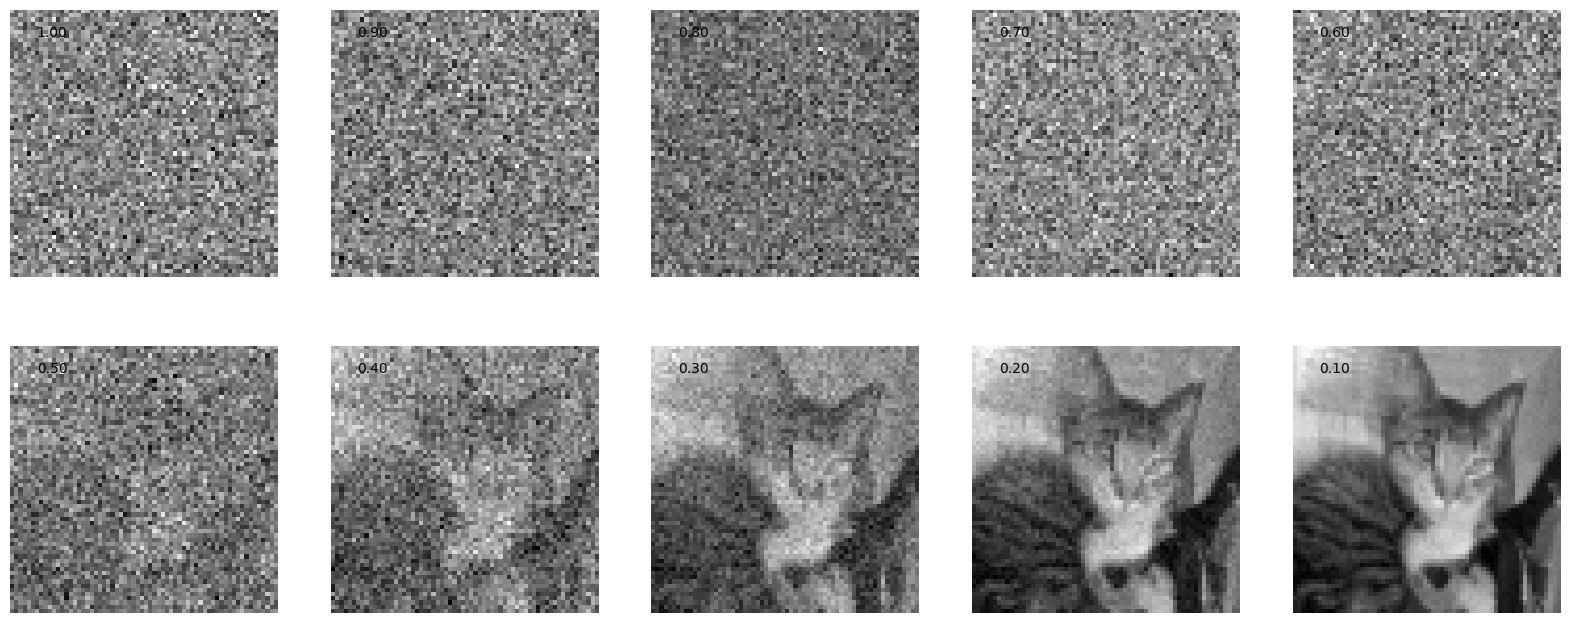

In [232]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

t = torch.linspace(1, 0, len(chain))

for k, ax in enumerate(axs.flatten()):
    ind = k * pred // 10
    ax.imshow(chain[ind].reshape(64, 64), cmap="gray")
    ax.annotate(f"{t[ind]:.2f}", xy=(0.1, 0.9), xycoords="axes fraction")
    ax.axis("off")

(700, 700)


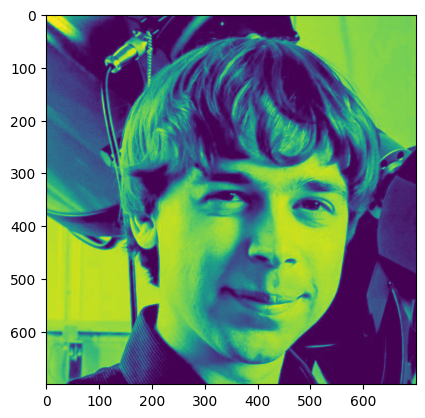

In [44]:
img = Image.open("/home/mjybarth/scratch/ConnorStone_Observatory-scaled.jpg")
print(np.asarray(img)[800:1500, 900:1600, 0].shape)
plt.imshow(np.asarray(img)[800:1500, 900:1600, 0])

In [59]:
class CropTransform:
    """Crop image"""

    def __init__(self, top, left, width, height):
        self.top = top
        self.left = left
        self.width = width
        self.height = height

    def __call__(self, x):
        return transforms.functional.crop(img = x, top = self.top, left = self.left, width = self.width, height = self.height)

data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomRotation(5),
        #transforms.RandomHorizontalFlip(),
        CropTransform(top = 800, left = 900, width = 700, height = 700),
        transforms.RandomResizedCrop(64, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        # normalize images to [-1, 1] range
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.Grayscale()
    ]),
}

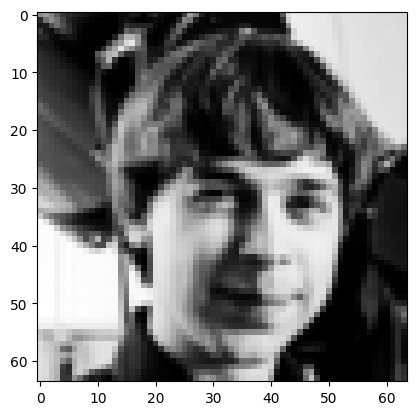

In [60]:
plt.imshow(data_transforms["train"](img)[0], cmap = "gray")

In [61]:
connor = data_transforms["train"](img)

In [62]:
connor.shape

torch.Size([1, 64, 64])

In [68]:
def euler_sampler(num_samples, num_steps, score_function, img_size = 64): 
    t = torch.ones(size = (num_samples, 1)).to(device)/2
    x = connor.flatten(start_dim = 1).to(device) * sigma(t)
    dt = -1/num_steps
    
    chain = []
    with torch.no_grad(): 
        for _ in (pbar := tqdm(range(num_steps - 1))): 
            pbar.set_description(f"t = {t[0].item():.2f} | scale ~ {x.std():.2e} | sigma(t) = {sigma(t)[0].item():.2e} | mu(t) = {mu(t)[0].item():.2e}")
            t += dt
            z = torch.randn_like(x).to(device)
            gradient = score_function(x, t)
            drift = drift_fn(t, x)
            diffusion = g(t, x)
            x_mean = x + drift * dt - diffusion**2 * gradient * dt  
            noise = diffusion * (-dt) ** 0.5 * z
            x = x_mean + noise
            
            chain.append(x.cpu().numpy())

            #print(score_likelihood(x, t))
            if torch.any(torch.isnan(x_mean)):
                print("Nans appearing")
                break
    
    return torch.flip(x_mean.reshape(num_samples, img_size, img_size), dims = (2,)), chain

In [69]:
pred = 1000
samples, chain = euler_sampler(num_samples = 1, num_steps = pred, score_function = score_posterior, img_size = 64)

t = -0.50 | scale ~ 5.24e-01 | sigma(t) = 1.02e-04 | mu(t) = 1.00e+00: 100%|██████████| 999/999 [00:17<00:00, 57.68it/s]


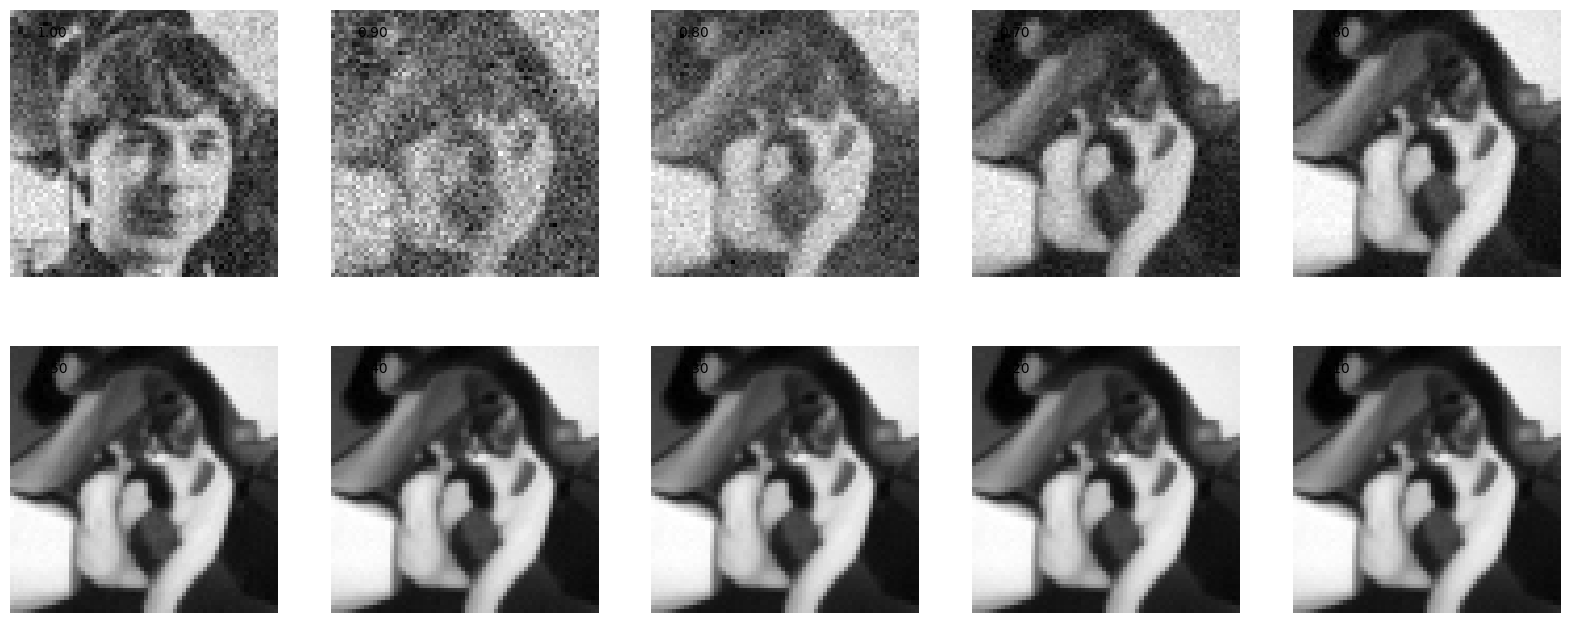

In [70]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

t = torch.linspace(1, 0, len(chain))

for k, ax in enumerate(axs.flatten()):
    ind = k * pred // 10
    ax.imshow(chain[ind].reshape(64, 64), cmap="gray")
    ax.annotate(f"{t[ind]:.2f}", xy=(0.1, 0.9), xycoords="axes fraction")
    ax.axis("off")

In [71]:
pred = 1000
samples, chain = euler_sampler(num_samples = 1, num_steps = pred, score_function = score_posterior, img_size = 64)

t = -0.50 | scale ~ 4.93e-01 | sigma(t) = 1.02e-04 | mu(t) = 1.00e+00: 100%|██████████| 999/999 [00:17<00:00, 57.80it/s]


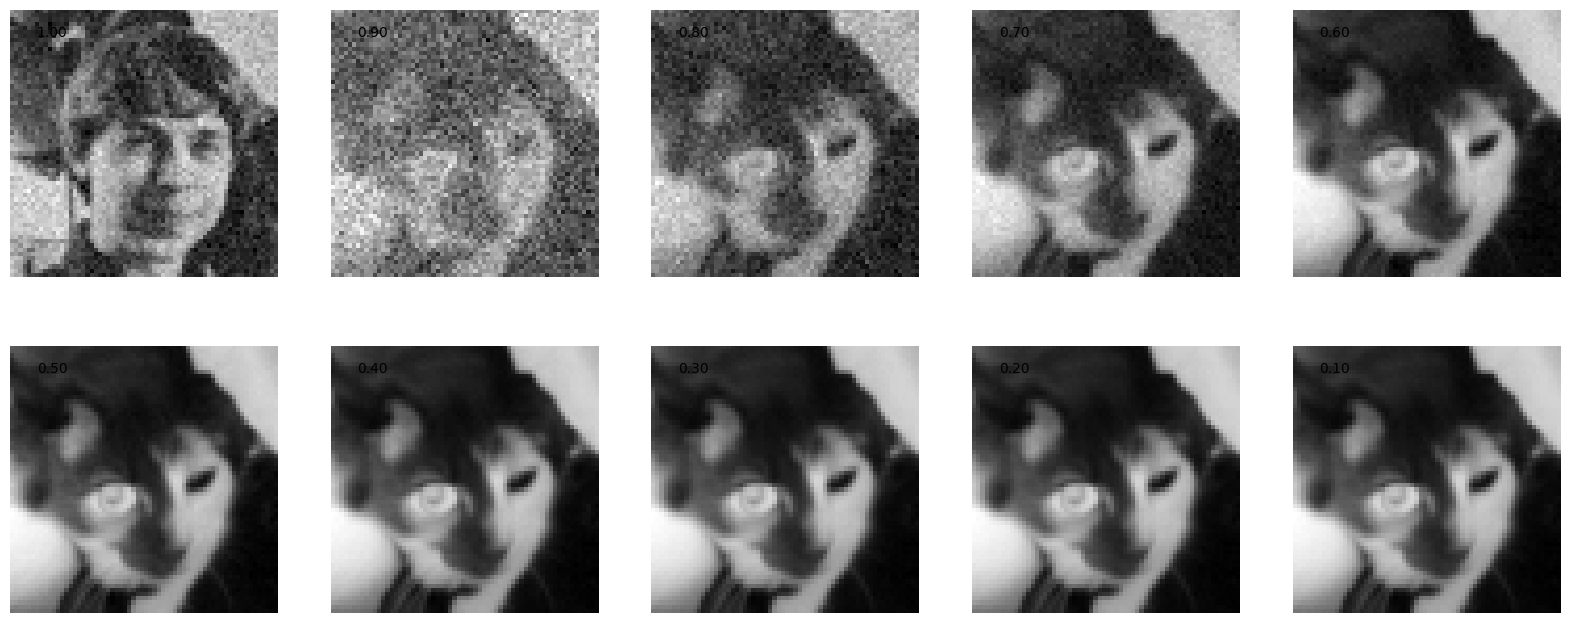

In [72]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

t = torch.linspace(1, 0, len(chain))

for k, ax in enumerate(axs.flatten()):
    ind = k * pred // 10
    ax.imshow(chain[ind].reshape(64, 64), cmap="gray")
    ax.annotate(f"{t[ind]:.2f}", xy=(0.1, 0.9), xycoords="axes fraction")
    ax.axis("off")

In [94]:
def euler_sampler(num_samples, num_steps, score_function, img_size = 64): 
    t = torch.ones(size = (num_samples, 1)).to(device)/1.8
    x = connor.flatten(start_dim = 1).to(device) * sigma(t)
    dt = -1/num_steps
    
    chain = []
    with torch.no_grad(): 
        for _ in (pbar := tqdm(range(num_steps - 1))): 
            pbar.set_description(f"t = {t[0].item():.2f} | scale ~ {x.std():.2e} | sigma(t) = {sigma(t)[0].item():.2e} | mu(t) = {mu(t)[0].item():.2e}")
            t += dt
            z = torch.randn_like(x).to(device)
            gradient = score_function(x, t)
            drift = drift_fn(t, x)
            diffusion = g(t, x)
            x_mean = x + drift * dt - diffusion**2 * gradient * dt  
            noise = diffusion * (-dt) ** 0.5 * z
            x = x_mean + noise
            
            chain.append(x.cpu().numpy())

            #print(score_likelihood(x, t))
            if torch.any(torch.isnan(x_mean)):
                print("Nans appearing")
                break
    
    return torch.flip(x_mean.reshape(num_samples, img_size, img_size), dims = (2,)), chain

In [95]:
pred = 1000
samples, chain = euler_sampler(num_samples = 1, num_steps = pred, score_function = score_posterior, img_size = 64)

t = -0.44 | scale ~ 7.66e-01 | sigma(t) = 1.70e-04 | mu(t) = 1.00e+00: 100%|██████████| 999/999 [00:17<00:00, 57.72it/s]


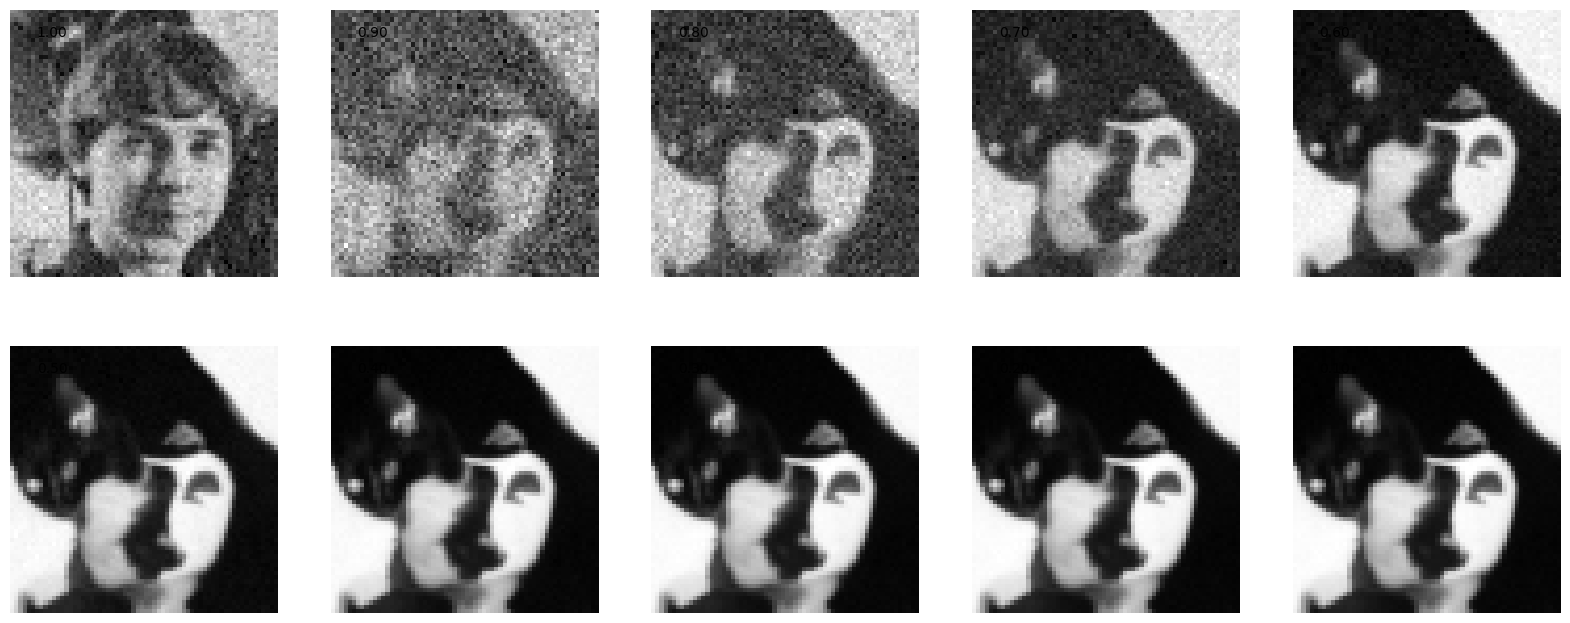

In [96]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

t = torch.linspace(1, 0, len(chain))

for k, ax in enumerate(axs.flatten()):
    ind = k * pred // 10
    ax.imshow(chain[ind].reshape(64, 64), cmap="gray")
    ax.annotate(f"{t[ind]:.2f}", xy=(0.1, 0.9), xycoords="axes fraction")
    ax.axis("off")

In [80]:
pred = 1000
samples, chain = euler_sampler(num_samples = 1, num_steps = pred, score_function = score_posterior, img_size = 64)

t = -0.44 | scale ~ 7.79e-01 | sigma(t) = 1.70e-04 | mu(t) = 1.00e+00: 100%|██████████| 999/999 [00:17<00:00, 57.88it/s]


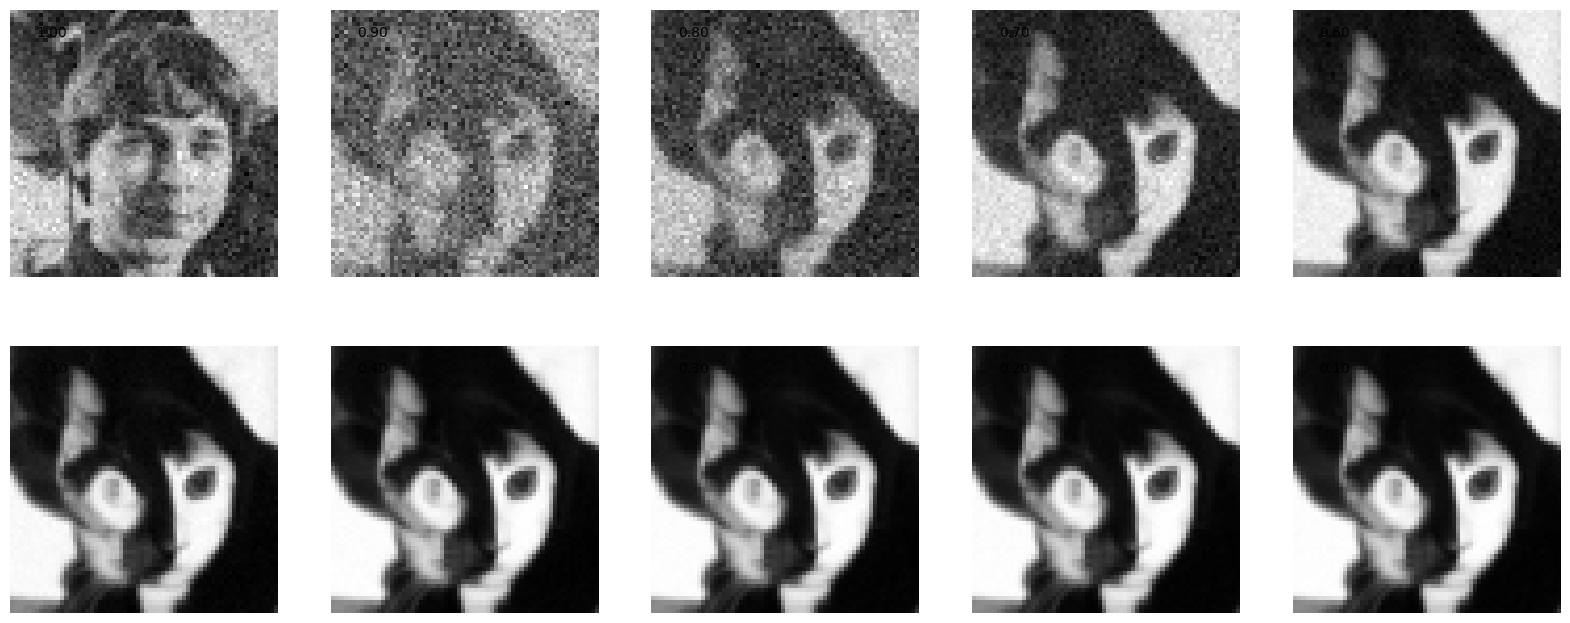

In [81]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

t = torch.linspace(1, 0, len(chain))

for k, ax in enumerate(axs.flatten()):
    ind = k * pred // 10
    ax.imshow(chain[ind].reshape(64, 64), cmap="gray")
    ax.annotate(f"{t[ind]:.2f}", xy=(0.1, 0.9), xycoords="axes fraction")
    ax.axis("off")

In [82]:
def euler_sampler(num_samples, num_steps, score_function, img_size = 64): 
    t = torch.ones(size = (num_samples, 1)).to(device)/3
    x = connor.flatten(start_dim = 1).to(device) * sigma(t)
    dt = -1/num_steps
    
    chain = []
    with torch.no_grad(): 
        for _ in (pbar := tqdm(range(num_steps - 1))): 
            pbar.set_description(f"t = {t[0].item():.2f} | scale ~ {x.std():.2e} | sigma(t) = {sigma(t)[0].item():.2e} | mu(t) = {mu(t)[0].item():.2e}")
            t += dt
            z = torch.randn_like(x).to(device)
            gradient = score_function(x, t)
            drift = drift_fn(t, x)
            diffusion = g(t, x)
            x_mean = x + drift * dt - diffusion**2 * gradient * dt  
            noise = diffusion * (-dt) ** 0.5 * z
            x = x_mean + noise
            
            chain.append(x.cpu().numpy())

            #print(score_likelihood(x, t))
            if torch.any(torch.isnan(x_mean)):
                print("Nans appearing")
                break
    
    return torch.flip(x_mean.reshape(num_samples, img_size, img_size), dims = (2,)), chain

In [85]:
pred = 1000
samples, chain = euler_sampler(num_samples = 1, num_steps = pred, score_function = score_posterior, img_size = 64)

t = -0.66 | scale ~ 1.11e-01 | sigma(t) = 2.19e-05 | mu(t) = 1.00e+00: 100%|██████████| 999/999 [00:17<00:00, 57.69it/s]


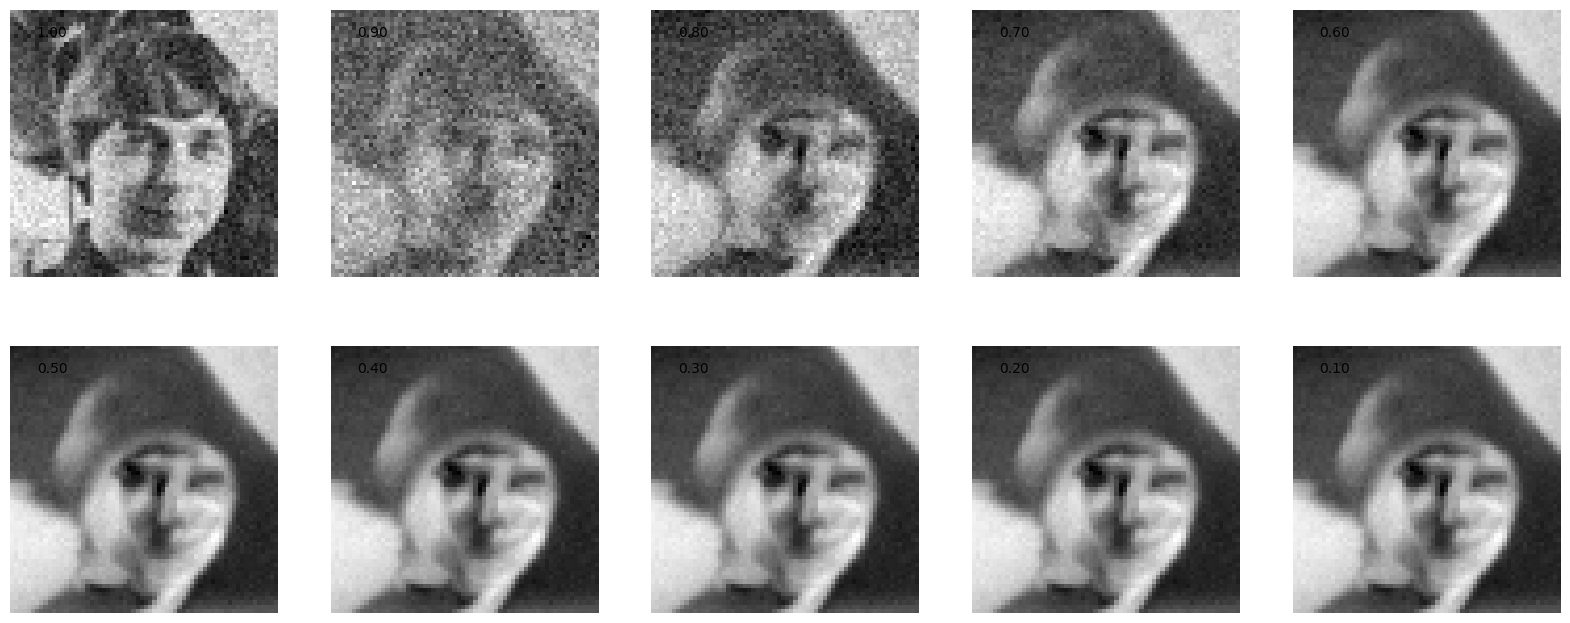

In [86]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

t = torch.linspace(1, 0, len(chain))

for k, ax in enumerate(axs.flatten()):
    ind = k * pred // 10
    ax.imshow(chain[ind].reshape(64, 64), cmap="gray")
    ax.annotate(f"{t[ind]:.2f}", xy=(0.1, 0.9), xycoords="axes fraction")
    ax.axis("off")

In [113]:
class CropTransform:
    """Crop image"""

    def __init__(self, top, left, width, height):
        self.top = top
        self.left = left
        self.width = width
        self.height = height

    def __call__(self, x):
        return transforms.functional.crop(img = x, top = self.top, left = self.left, width = self.width, height = self.height)

data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomRotation(5),
        #transforms.RandomHorizontalFlip(),
        CropTransform(top = 900, left = 1000, width = 550, height = 550),
        transforms.RandomResizedCrop(64, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        # normalize images to [-1, 1] range
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.Grayscale()
    ]),
}

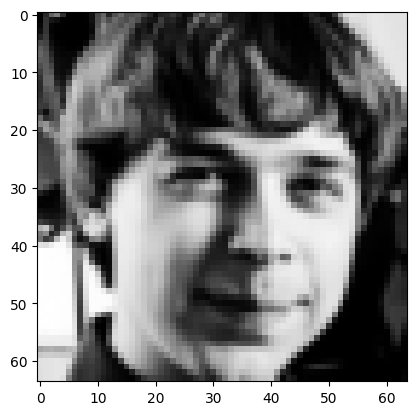

In [114]:
plt.imshow(data_transforms["train"](img)[0], cmap = "gray")

In [115]:
connor = data_transforms["train"](img)

In [164]:
def euler_sampler(num_samples, num_steps, score_function, img_size = 64): 
    t = torch.ones(size = (num_samples, 1)).to(device)/2
    x = connor.flatten(start_dim = 1).to(device) * sigma(t)
    dt = -1/num_steps
    
    chain = []
    with torch.no_grad(): 
        for _ in (pbar := tqdm(range(num_steps - 1))): 
            pbar.set_description(f"t = {t[0].item():.2f} | scale ~ {x.std():.2e} | sigma(t) = {sigma(t)[0].item():.2e} | mu(t) = {mu(t)[0].item():.2e}")
            t += dt
            z = torch.randn_like(x).to(device)
            gradient = score_function(x, t)
            drift = drift_fn(t, x)
            diffusion = g(t, x)
            x_mean = x + drift * dt - diffusion**2 * gradient * dt  
            noise = diffusion * (-dt) ** 0.5 * z
            x = x_mean + noise
            
            chain.append(x.cpu().numpy())

            #print(score_likelihood(x, t))
            if torch.any(torch.isnan(x_mean)):
                print("Nans appearing")
                break
    
    return torch.flip(x_mean.reshape(num_samples, img_size, img_size), dims = (2,)), chain

In [165]:
pred = 700
samples, chain = euler_sampler(num_samples = 1, num_steps = pred, score_function = score_posterior, img_size = 64)

t = -0.50 | scale ~ 4.94e-01 | sigma(t) = 1.03e-04 | mu(t) = 1.00e+00: 100%|██████████| 699/699 [00:12<00:00, 57.56it/s]


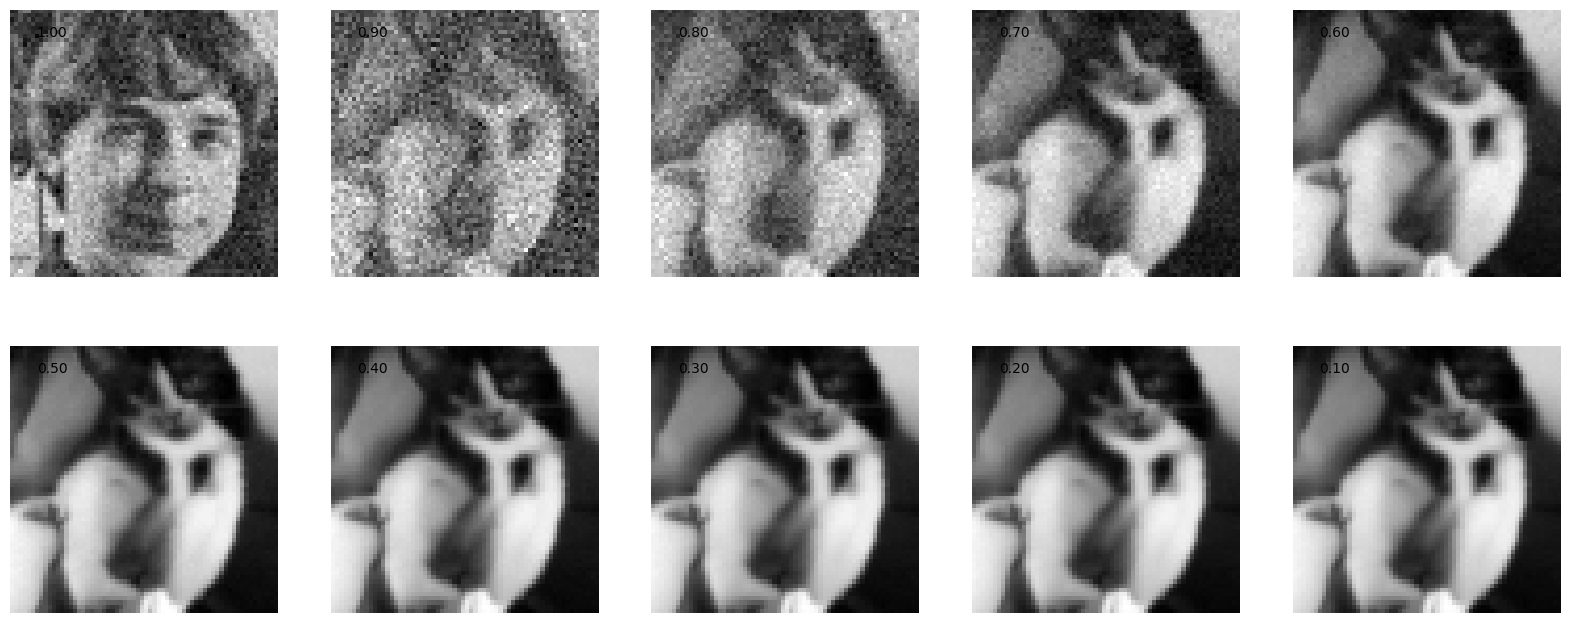

In [166]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

t = torch.linspace(1, 0, len(chain))

for k, ax in enumerate(axs.flatten()):
    ind = k * pred // 10
    ax.imshow(chain[ind].reshape(64, 64), cmap="gray")
    ax.annotate(f"{t[ind]:.2f}", xy=(0.1, 0.9), xycoords="axes fraction")
    ax.axis("off")

In [167]:
pred = 700
samples, chain = euler_sampler(num_samples = 1, num_steps = pred, score_function = score_posterior, img_size = 64)

t = -0.50 | scale ~ 5.08e-01 | sigma(t) = 1.03e-04 | mu(t) = 1.00e+00: 100%|██████████| 699/699 [00:12<00:00, 57.77it/s]


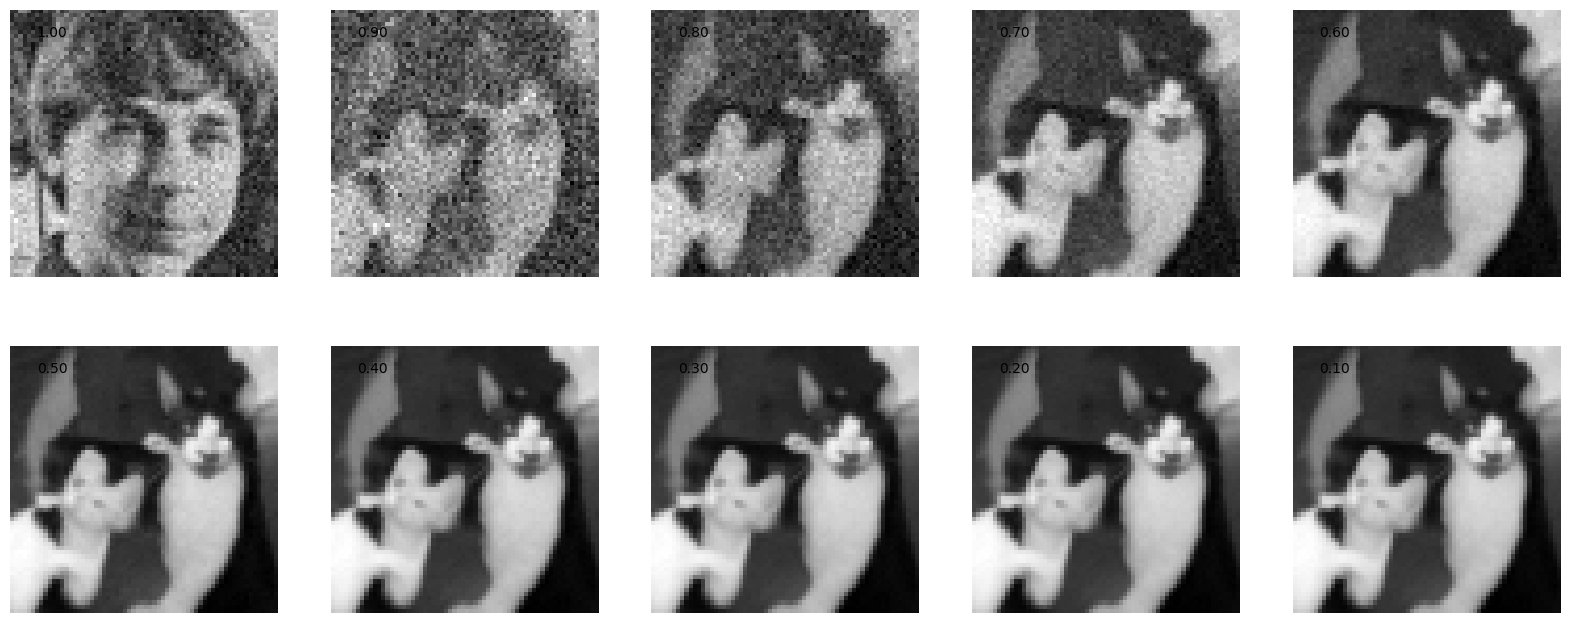

In [168]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

t = torch.linspace(1, 0, len(chain))

for k, ax in enumerate(axs.flatten()):
    ind = k * pred // 10
    ax.imshow(chain[ind].reshape(64, 64), cmap="gray")
    ax.annotate(f"{t[ind]:.2f}", xy=(0.1, 0.9), xycoords="axes fraction")
    ax.axis("off")

In [175]:
pred = 700
samples, chain = euler_sampler(num_samples = 1, num_steps = pred, score_function = score_posterior, img_size = 64)

t = -0.50 | scale ~ 4.82e-01 | sigma(t) = 1.03e-04 | mu(t) = 1.00e+00: 100%|██████████| 699/699 [00:12<00:00, 57.63it/s]


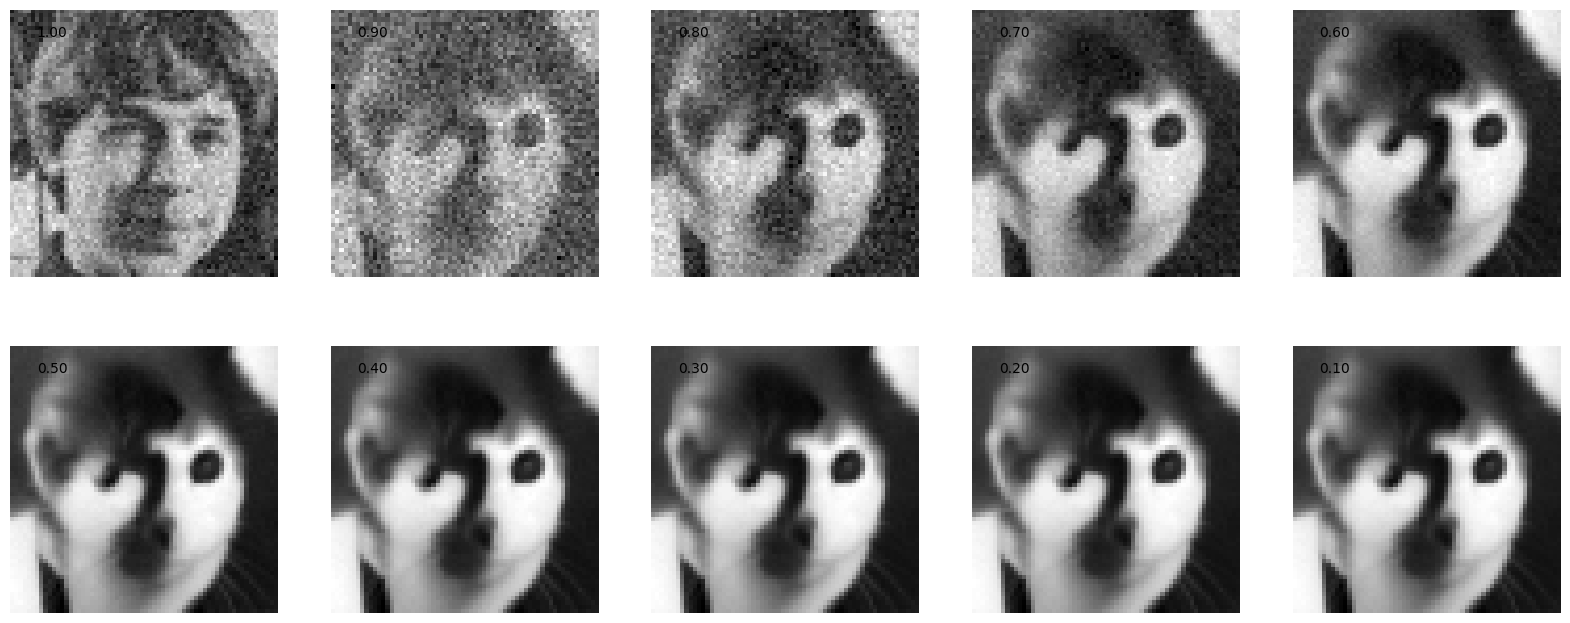

In [176]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

t = torch.linspace(1, 0, len(chain))

for k, ax in enumerate(axs.flatten()):
    ind = k * pred // 10
    ax.imshow(chain[ind].reshape(64, 64), cmap="gray")
    ax.annotate(f"{t[ind]:.2f}", xy=(0.1, 0.9), xycoords="axes fraction")
    ax.axis("off")

In [205]:
pred = 750
samples, chain = euler_sampler(num_samples = 1, num_steps = pred, score_function = score_posterior, img_size = 64)

t = -0.50 | scale ~ 4.84e-01 | sigma(t) = 1.02e-04 | mu(t) = 1.00e+00: 100%|██████████| 749/749 [00:13<00:00, 57.34it/s]


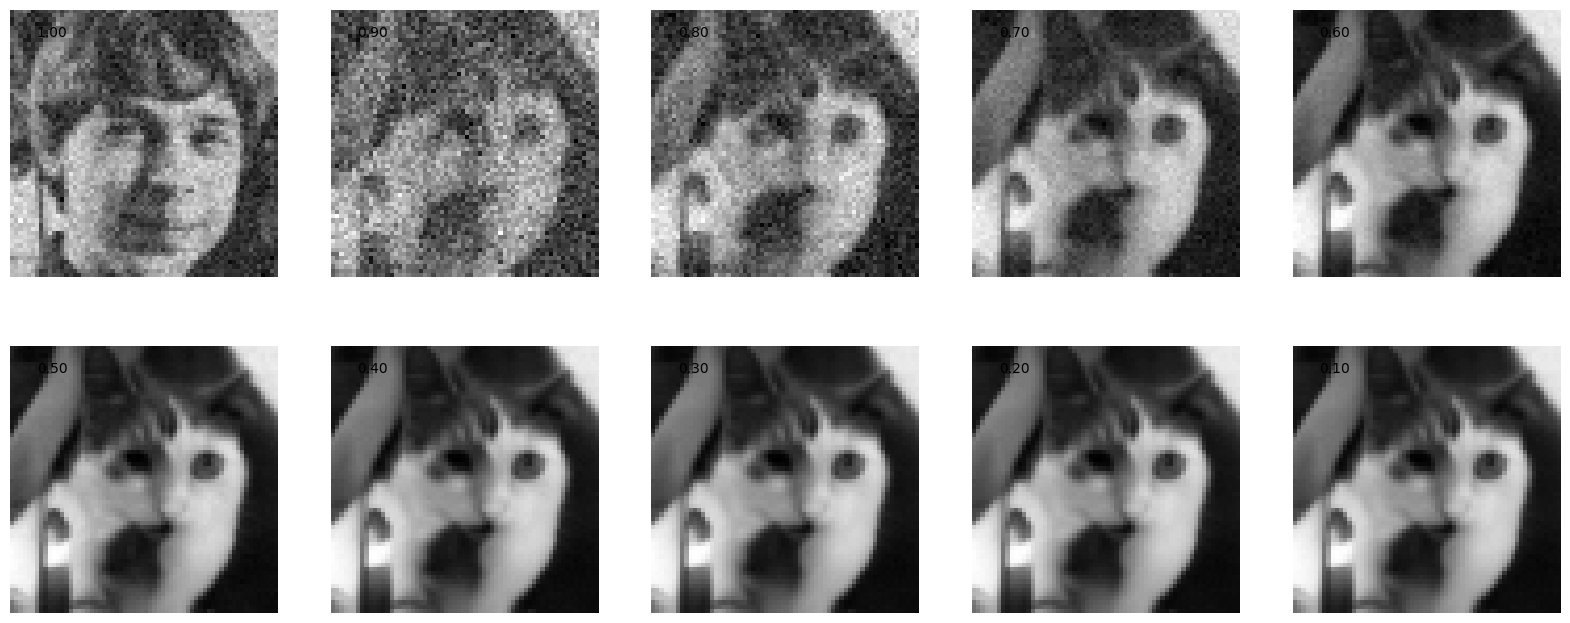

In [206]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

t = torch.linspace(1, 0, len(chain))

for k, ax in enumerate(axs.flatten()):
    ind = k * pred // 10
    ax.imshow(chain[ind].reshape(64, 64), cmap="gray")
    ax.annotate(f"{t[ind]:.2f}", xy=(0.1, 0.9), xycoords="axes fraction")
    ax.axis("off")

In [218]:
pred = 250
samples, chain = euler_sampler(num_samples = 1, num_steps = pred, score_function = score_posterior, img_size = 64)

t = -0.49 | scale ~ 4.81e-01 | sigma(t) = 1.08e-04 | mu(t) = 1.00e+00: 100%|██████████| 249/249 [00:04<00:00, 59.11it/s]


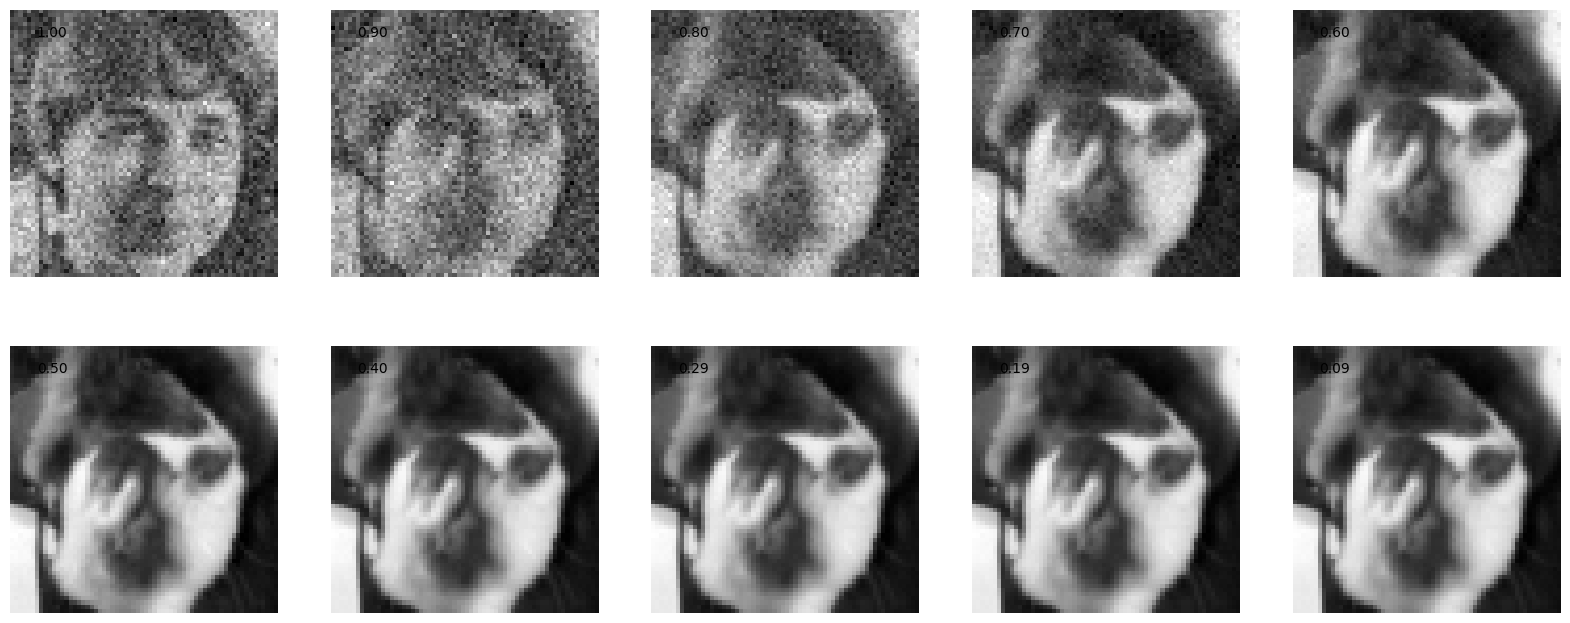

In [219]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

t = torch.linspace(1, 0, len(chain))

for k, ax in enumerate(axs.flatten()):
    ind = k * pred // 10
    ax.imshow(chain[ind].reshape(64, 64), cmap="gray")
    ax.annotate(f"{t[ind]:.2f}", xy=(0.1, 0.9), xycoords="axes fraction")
    ax.axis("off")

In [233]:
def euler_sampler(num_samples, num_steps, score_function, img_size = 64): 
    t = torch.ones(size = (num_samples, 1)).to(device)/2
    x = connor.flatten(start_dim = 1).to(device) * sigma(t)
    dt = -1/num_steps
    
    chain = []
    with torch.no_grad(): 
        for _ in (pbar := tqdm(range(num_steps - 1))): 
            pbar.set_description(f"t = {t[0].item():.2f} | scale ~ {x.std():.2e} | sigma(t) = {sigma(t)[0].item():.2e} | mu(t) = {mu(t)[0].item():.2e}")
            t += dt
            z = torch.randn_like(x).to(device)
            gradient = score_function(x, t)
            drift = drift_fn(t, x)
            diffusion = g(t, x)
            x_mean = x + drift * dt - diffusion**2 * gradient * dt  
            noise = diffusion * (-dt) ** 0.5 * z
            x = x_mean + noise
            
            chain.append(x.cpu().numpy())

            #print(score_likelihood(x, t))
            if torch.any(torch.isnan(x_mean)):
                print("Nans appearing")
                break
    
    return torch.flip(x_mean.reshape(num_samples, img_size, img_size), dims = (2,)), chain

In [238]:
pred = 750
samples, chain = euler_sampler(num_samples = 1, num_steps = pred, score_function = score_posterior, img_size = 64)

t = -0.50 | scale ~ 4.64e-01 | sigma(t) = 1.02e-04 | mu(t) = 1.00e+00: 100%|██████████| 749/749 [00:12<00:00, 58.90it/s]


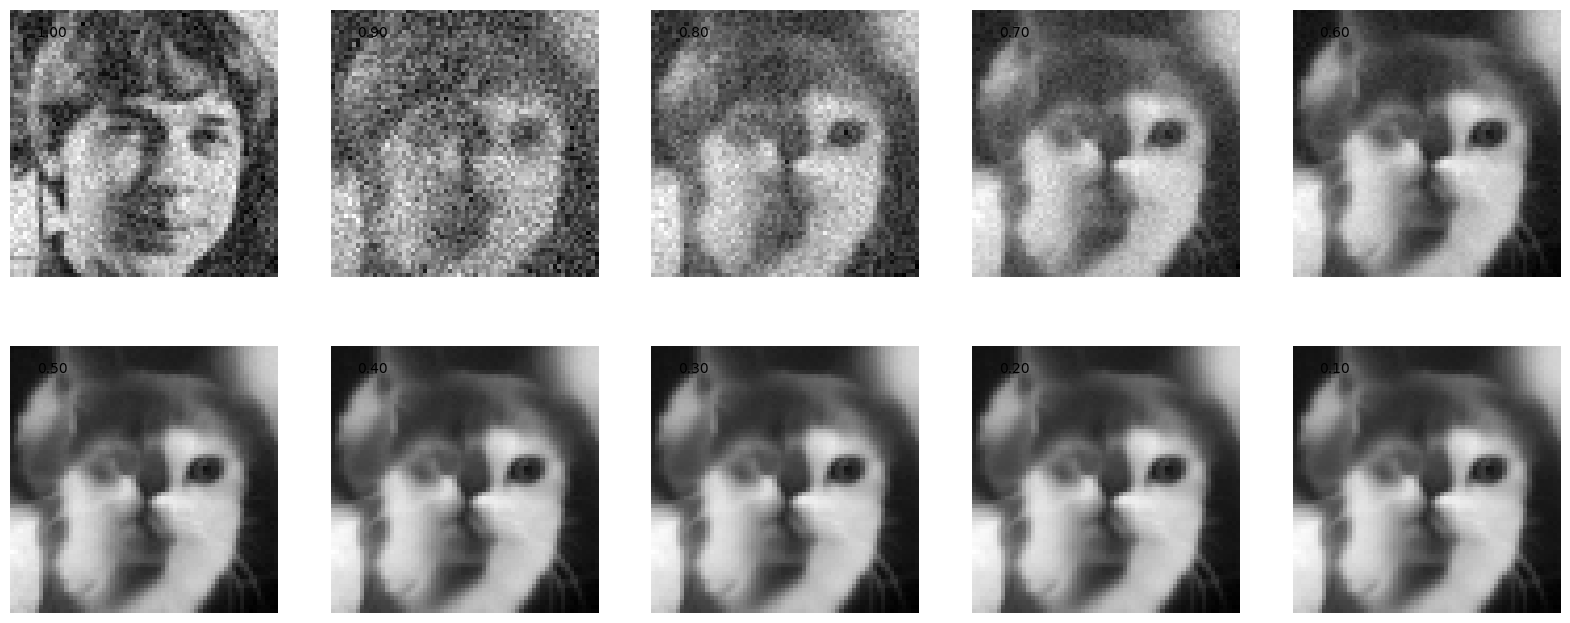

In [239]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

t = torch.linspace(1, 0, len(chain))

for k, ax in enumerate(axs.flatten()):
    ind = k * pred // 10
    ax.imshow(chain[ind].reshape(64, 64), cmap="gray")
    ax.annotate(f"{t[ind]:.2f}", xy=(0.1, 0.9), xycoords="axes fraction")
    ax.axis("off")